In [3]:
from collections import defaultdict, Counter
import elotl.corpus
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import statsmodels.api as sm
import os
from re import sub

In [4]:
def processSentence(sentence):
    sentence = sub(r'[^\w\s]',' ',sentence)     #Sustituimos signos de puntuación por un espacio
    sentence = sentence.lower().split()
    return sentence

In [5]:
def getWordsBySentence(corpus):
    corpusEs=[]
    corpusEx=[] 
    for row in corpus:  
        if len(row[0].split(" ")) > 1:
            corpusEs.append(processSentence(row[0]))
        if len(row[1].split(" ")) > 1:
            corpusEx.append(processSentence(row[1]))
    return corpusEs,corpusEx

In [6]:
corpusNahuatl=elotl.corpus.load('axolotl')  #español-náhuatl 
corpusOtomi=elotl.corpus.load('tsunkua')  #español-otomi 

In [7]:
oraciones = getWordsBySentence(corpusNahuatl)
lenguajes = ["español","nahuatl"]

In [8]:
def buildConcurrencyNetwork(sentencesList,name=""):
    words = [item for lis in sentencesList for item in lis]
    concDG = nx.DiGraph()
    concDG.add_nodes_from(set(words))
    for sentence in sentencesList:
        concDG.add_edges_from(zip(sentence[:-1],sentence[1:]))
    if name:
        nx.readwrite.graphml.write_graphml(concDG,os.path.join("networks","{0}.graphml".format(name)))
    return concDG

In [12]:
G = buildConcurrencyNetwork(oraciones[0])

In [13]:
def makeLogLogFit(xs,ys):
    indexes = [i for i in range(len(xs)) if (xs[i]>0 and ys[i]>0)]
    xs = [xs[i] for i in indexes]
    ys = [ys[i] for i in indexes]
    xsfit = sm.add_constant(np.log(xs))
    # build model and train
    mod = sm.OLS(exog=xsfit,endog=np.log(ys))
    fit = mod.fit()
    # make list of predicted data
    ysfit = [np.exp(y) for y in fit.predict(xsfit)]
    # plotting results
    return fit, ysfit

In [14]:
def plotLogLogFit(xs,ysfit,fit,textbox=False,r1=4):
    plt.plot(xs,ysfit,label="Power law fit")
    textstr = "y = {0} x^({1}) \n R^2 = {2}".format(round(np.exp(fit.params[0]),r1),round(fit.params[1],r1),round(fit.rsquared,8))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.95,0.95, textstr,transform=plt.gca().transAxes,  fontsize=14,va='top',ha="right", bbox=props)

In [15]:
def plotLogLog(xs,ys,title,fit=True,norm=True):
    if norm:
        s = sum(ys)
        ys = [y/s for y in ys]
        plt.ylabel("Normalized Frecuency")
    else:
        plt.ylabel("Frecuency")
    plt.plot(xs,ys,label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(title)
    plt.grid()
    if fit:
        fit, ysfit = makeLogLogFit(xs,ys)
        # plotting results
        plotLogLogFit(xs,ysfit,fit)

In [16]:
def plotDegreeDistributions(G,title,bins=20,fit=False,norm=True):
    if type(G) == nx.classes.digraph.DiGraph:
        degs = ["degree","in_degree","out_degree"]
    else:
        degs = ["degree"]
    for deg in degs:
        func = getattr(G,deg)
        degreeSequence = sorted([d for n,d in func()])
        degreeCounter = Counter(degreeSequence)
        degrees, count = zip(*degreeCounter.items())
        plt.figure()
        plotLogLog(degrees,count,"{1} \n {0} distribution".format(deg.replace("_"," "),title),fit=fit,norm=norm)
        plt.show()

In [17]:
def plotBinnedDegreeDistributions(G,title,bins=20,fit=False,norm=True):
    if type(G) == nx.classes.digraph.DiGraph:
        degs = ["degree","in_degree","out_degree"]
    else:
        degs = ["degree"]
    for deg in degs:
        func = getattr(G,deg)
        degreeSequence = sorted([d for n,d in func()])
        m1 = degreeSequence[0]
        m2 = degreeSequence[-1]
        if m1==0:
            m1=1
        A = np.logspace(np.log10(m1),np.log10(m2),bins)
        plt.figure()
        if norm:
            weights = np.ones_like(degreeSequence) / float(len(degreeSequence))
            B = plt.hist(degreeSequence,bins=A,ec="k",weights=weights)
            plt.ylabel("Normalized frecuency")
        else: 
            B = plt.hist(degreeSequence,bins=A,ec="k")
            plt.ylabel("Frecuency")
        indexes = [i for i in range(len(A)-1) if B[0][i] > 0]
        xs = [(A[i]+A[i+1])/2 for i in indexes]
        ys = [B[0][i] for i in indexes]
        fit, ysfit = makeLogLogFit(xs,ys)
        plotLogLogFit(xs,ysfit,fit)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Degree")
        
        plt.title("{1} \n {0} binned distribution".format(deg.replace("_"," "),title))
        plt.grid()
        

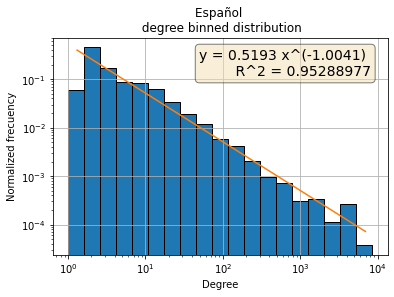

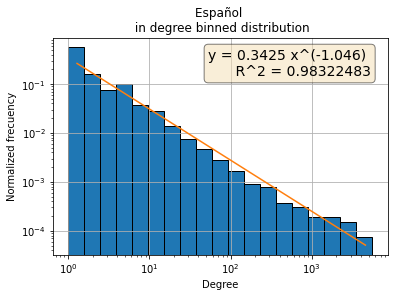

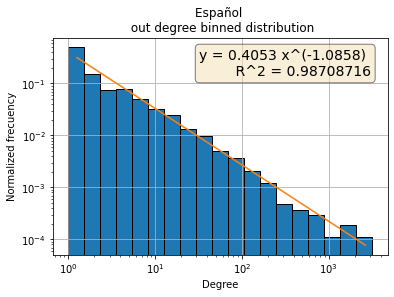

In [18]:
plotBinnedDegreeDistributions(G,"Español")